`moth` is a NumPy based implementation of moth-inspired navigation strategies that uses 
`pompy` library to create the puff, wind and concentration models. see `pompy/Readme.md` 
for details

### What is this repository for?

This Python package allows simulation moth-like navigators in dynamic 2D odour 
concentration fields spread in turbulent flows 

### Installation and requirements

    Python 2.7
    Numpy
    Scipy
    Matplotlib

### Example usage
![Demo flight](moth/Demonstration_of_different_navigation_strategies.png)


The following code simulates a meandering plume, runs naviagatores through the plume simulation, and prints out the navigation statistics of the run. 
Firstly, the function generate_job generates the job.json file that holds all of the needed information to run a simulation, divided to sections. 

In [1]:
from __future__ import division
import json
def generate_job(char_time =3.5,amplitude =0.1,
                 job_file='job.json', puff_release_rate = 10, puff_spread_rate =0.003,
                  t_max =75., dt = 0.01,num_it =1, base_duration =0.2):
    const_dict={}

    #simulation
    const_dict['num_it'] = num_it
    const_dict['t_max'] = t_max
    const_dict['dt'] = dt

    #wind meandering
    const_dict['char_time'] = char_time
    const_dict['amplitude'] = amplitude

    #plume source
    const_dict['puff_release_rate'] = puff_release_rate
    const_dict['puff_spread_rate'] = puff_spread_rate
    
    #navigators
    const_dict['x_start'] = 100
    const_dict['y_start'] = 500
    const_dict['nav_type'] = 'alex'
    const_dict['wait_type'] = 1
    const_dict['base_turn_angle'] = 18 #for crw
    const_dict['threshold'] = 500
    const_dict['duration'] = base_duration
    
    with open(job_file, 'w') as outfile:
        json.dump(const_dict, outfile)

This file creates trajectory data.
Note - In this file we only define a function, there is no actual output.

#### Set up the navigators (optional) 
The file Casting_competition initiates the navigators to run in the simulation. 
The next segment defines create_trajectory_data that opens the job.json file and initiates a navigator object (moth_modular) using the predefined parameters. 
The inner function call_navigators sets two hundred navigators of a certein waiting, casting and navigating type. The only difference between the navigators is their initial location - navigator.x, navigator.y.
If you wish to set different navigators to, change the input with which call_navigators is called. 
The function then calls moth_simulation (not shown in this prenstation) and saves the trajectory data it generates as a .json file. 


In [2]:
from __future__ import division

__authors__ = 'Noam Benelli'
import models
from simulation import moth_simulation
import copy


def create_trajectory_data(job_file_name = 'job.json',data_file_name ='data.json',
                           titles_file_name = 'titles.json'):
    with open(job_file_name) as data_file:
        cd = json.load(data_file) #constants dictionary
    sim_region = models.Rectangle(0., -1., 4., 1.)


    #call the base navigator. the competing navigators in the simulation retain
    #any parameter of navigator1 that isn't changed
    navigator1 = models.moth_modular(sim_region, cd['x_start'], cd['y_start'],cd['nav_type'] , 2, cd['wait_type'])
    navigator1.base_turn_angle = cd['base_turn_angle']
    navigator1.threshold = cd['threshold']
    navigator1.duration = cd['duration']

    
    #set up a large number of navigators with different properties
    navigators = []
    navigator_titles = []


    def call_navigators(wait,cast,nav):
        for j in range(10):
            for i in range(20):
                new_navigator = copy.copy(navigator1)
                new_navigator.wait_type = wait
                new_navigator.cast_type = cast
                new_navigator.nav_type = nav
                new_navigator.y = 450 - i*3
                new_navigator.x = 499 - j

            title =  \
                ' cast - ' + str(new_navigator.cast_type) \
                + '; nav - ' + str(new_navigator.nav_type) \
                + str(len(navigators))
                
            navigators.append(new_navigator)
            navigator_titles.append(title)
    
    call_navigators(1,2,'alex')
    call_navigators(1,3,'alex')
    call_navigators(1,'carde2',1)
    call_navigators(1,'carde1',1)
     
    #run the simulation - each navigator runs through the exact same conditions
    dict_list = moth_simulation(cd['num_it'],
                                navigators,cd['t_max'],cd['char_time'],
                                cd['amplitude'], cd['dt'], cd['puff_release_rate'],
                                cd['puff_spread_rate'],
                                1,
                                False)


    with open(data_file_name, 'w') as outfile:
        json.dump(dict_list, outfile)
    return navigator_titles
    


#### Set up the wind and plume conditions (optional) 
The next segment initiates the main loop. For each iteration a new plume and wind model are initiated for the navigators to be simulated in. The function generate_job dictates the terms of the simulation in terms of wind and plume partameteres. In order to set the simulation enter the required parameters as input for generate_job. Those will be written into the corrsponding job files. 
In order to create a gradient between the iterations, define the parameter using the loop index i.
For example, as the simulation is set now, the only value that changes is the puff spread rate, varying from 0.0001 to 0.0004.
Make sure that only one variable of the simulation changes with each iteration.
#### Run The simulations
When the file is run the wind and plume paramters that have been set are saved into "job" files, one JSON file for each iteration (job0.JSON, job1.JSON...). 
The trajectories of the navigators are saved as "data" files, (data0.JSON, data1.JSON), on which the later analyses will be made. 
Notice the following line - 
```
#save_plot(job_file_name,data_file_name,title,navigator_titles)
```
Deleting the # mark would cause the code to save an image for each navigation attempt (800 pictures total). That could supply useful input in some cases. 

Note - This part might take a while.
   

In [3]:
from graphics_from_file import save_plot, save_detection_plot

if __name__ == "__main__":
    for i in range(4):
        job_file_name = 'job'+ str(i)+ '.json'
        data_file_name = 'data'+ str(i)+ '.json'
        generate_job(char_time = 7, amplitude = 0.1, job_file = job_file_name,
                     t_max =20, puff_release_rate = 100,
                     puff_spread_rate = 0.0001*(1+i),
                     dt = 0.01, num_it = 1)
        navigator_titles = create_trajectory_data(job_file_name,data_file_name)
        title = 'loop ' +str(i) 
        #save_plot(job_file_name,data_file_name,title,navigator_titles)
        #save_detection_plot(job_file_name,data_file_name,navigators_titles)
        print ('finished simulation number ' + str(i+1))
        

finished simulation number 1
finished simulation number 2
finished simulation number 3
finished simulation number 4


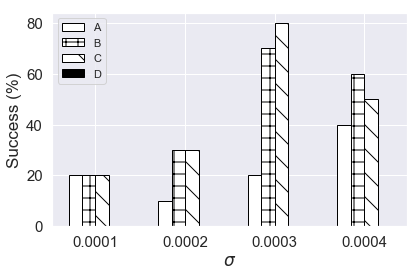

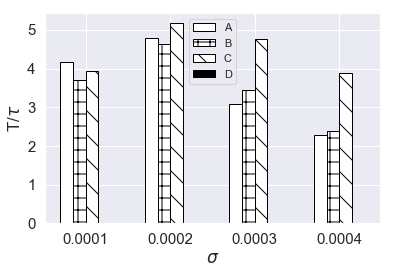

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from bars import get_data

__authors__ = 'Noam Benelli'

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)


def create_line_graphs(tot_stats,int_loop):
    # nav_titles = ('Liberzon','Benelli','Large Final Sweeps','Final Sweeps')
    # colors = ('green','red','blue','yellow')
    # loop = str(int_loop)

    plt.figure()
    for stats in tot_stats:
        plt.plot(stats)
        # plt.ylabel('')

def detect_change(job_list):
    for key in job_list[0]:
        if job_list[0][key] != job_list[1][key]:
            sig_key = key
            break
    value_list =[]
    for job in job_list:
        value_list.append(job[sig_key])
        
    return (sig_key, value_list)

def process_jobs(num_jobs):
    job_list = []
    for i in range(num_jobs):
        file_name = 'job'+str(i)+'.json'
        with open(file_name) as data_file1:  
            job = json.load(data_file1)
        job_list.append(job)
    return detect_change(job_list)
def present_graphs():
    num_jobs = 4
    (xlabel,values)=process_jobs(num_jobs)
    legends = ('A','B','C','D')
    liberzonlist =[]
    Benellilist = []
    lfslist =[]
    fslist = []
    for i in range(num_jobs):
        loop = str(i)
        data_list = get_data('data'+loop+'.json',4)
        #print (data_list[0])
        liberzonlist.append(data_list[0])
        Benellilist.append((data_list[1]))
        lfslist.append((data_list[2]))
        fslist.append((data_list[3]))
    #[succ_prec ,average_time_,average_efficiency]
    lib_succ, lib_avg,lib_efficiency = zip(*liberzonlist)
    Bene_succ, Bene_avg,Bene_efficiency = zip(*Benellilist)
    lfs_succ, lfs_avg, lfs_efficiency = zip(*lfslist)
    fs_succ, fs_avg,fs_efficiency = zip(*fslist)


    fig,ax = plt.subplots()

    n_groups = 4
    bar_width = 0.3
    opacity = 0.4
    index = np.arange(0, 2*n_groups, 2)
    """
    data0 =(lib_succ[0],Bene_succ[0],lfs_succ[0],fs_succ[0])
    data1 =(lib_succ[1],Bene_succ[1],lfs_succ[1],fs_succ[1])
    data2 =(lib_succ[2],Bene_succ[2],lfs_succ[2],fs_succ[2])
    data3 =(lib_succ[3],Bene_succ[3],lfs_succ[3],fs_succ[3])
    """
    def set_charts(data0,data1,data2,data3):
        global chart
        chart = plt.bar(index, data0, bar_width,color = 'white', edgecolor='black')
        chart = plt.bar(index+bar_width, data1, bar_width,color = 'white', hatch = '+' ,edgecolor='black')
        chart = plt.bar(index+2*bar_width, data2, bar_width,color = 'white', hatch = '\\', edgecolor='black')
        chart = plt.bar(index+3*bar_width, data3, bar_width,color = 'black', hatch = '*', edgecolor='black')
    set_charts(lib_succ,Bene_succ,lfs_succ,fs_succ)
    if xlabel == 'puff_spread_rate':
        ax.set_xlabel(r'$\sigma$')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Success (%)')
    ax.xaxis.label.set_fontsize(17)
    ax.yaxis.label.set_fontsize(17)
    #ax.set_title('Success Percentage vs '+ xlabel)
    plt.xticks(index+bar_width*1.5, (str(values[0]), str(values[1]), str(values[2]),str(values[3])))
    plt.legend(legends)
    plt.tight_layout()


    plt.savefig('Success Percentage vs '+ xlabel)
    plt.show()
    
    #create second graph
    fig,ax = plt.subplots()

    n_groups = 4
    bar_width = 0.3
    opacity = 0.4
    index = np.arange(0, 2*n_groups, 2)
    
    #plt.xlabel(xlabel)
    #plt.ylabel('Average Navigation Time (ratio)')
    if xlabel == 'puff_spread_rate':
        ax.set_xlabel(r'$\sigma$')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('T/'+r'$\tau$')

    
    set_charts(lib_avg,Bene_avg,lfs_avg,fs_avg)
    plt.subplots_adjust(bottom=0.15)
    plt.xticks(index+bar_width*1.5, (str(values[0]), str(values[1]), str(values[2]),str(values[3])))
    #ax.set_title('Average Navigation Time vs '+ xlabel)
    ax.xaxis.label.set_fontsize(17)
    ax.yaxis.label.set_fontsize(17)
    plt.legend(legends)
    plt.savefig('Average Navigation Time vs '+ xlabel)
    plt.show()
present_graphs()

## How to manage and design navigators
This short guide will explain how to design your own brand of navigator, run in through a plume simulation and compare its performance to that of other navigators. 
### Initiating  a navigator
Let us look at this example from the casting_competition file:
```
navigator1 = models.moth_modular(sim_region, cd['x_start'], cd['y_start'], cd['nav_type'] , cd['cast_type'], cd['wait_type'])
```
The navigator is initiated with it's initial x and y coordinates and the modes of navigating, casting and waiting. 
### Wait, cast and nav types
Waiting, casting and navigating are the three different stages of movement the define the behaviour of a navigator. 
The navigator constantly measures odor concetration in its environment and compares it to a preset threshold. 
Waiting is the movement type performed up until the first time the navigator detects odor (for each navigator presented in this presentation, waiting is passive, the navigator just waits for odor to reach it). Navigating is the mode of movement performed while odor is detected. Casting it the mode of movement performed when odor is lost. 
A navigator is an object of the ```moth_modular``` class. It has an attribute to define each movement type, ```wait_type, cast_type, nav_type```. 
The attribute itself can be an integer or a string, it doesn't matter, but it should correlate to a signifier inside of the corresponding function. For example, let's look at the casting function -
```
def cast(self,wind_vel_at_pos):
        if self.state != 'cast' :
            #if this is the beginging of a new casting phase
            self.change_direction()
            
        if self.cast_type == 0:
            self.u=0
            self.v=0
            
        if self.cast_type == 1:
            self.calculate_wind_angle(wind_vel_at_pos)
            self.u = -self.speed*np.cos(self.gamma+self.wind_angle)
            self.v = self.speed*np.sin(self.gamma+self.wind_angle)

        if self.cast_type == 2:
            #define different betas for different casting patterns
            self.cast2(wind_vel_at_pos)
```
The function, like all movement functions, takes as input the parameters of the navigator and the wind velocity at the position (as calculated by the wind model).
The first conditional changes the direction of casting from the previous direction. This has nothing to with the cast type. 
The second, third and fourth conditionals are dependant on the cast type, and use it as an indicator as to how to move. Note that the function can call upon other functions. The stracture of the ```wait``` and ```navigate``` are very similar - The function sets the velocity (u,v) of the navigator. The actual time step is performed in the update function.
#### defining new movement types
In order to create a new waiting, casting or navigation, first enter the models file. For example, let's say we would like to design a new waiting mode. First, we sould define a condition within the waiting function. 
```
    def wait(self,wind_vel_at_pos):
        if wait_type == 'example wait type':
```
Now, if the navigator was initiated to so its wait type attribute is 'example wait type' the wait function will be directed into the actions we define under that conditional. Secondly, define the changes in you would like to be made to the velocity of the navigator:
```
    def wait(self,wind_vel_at_pos):
        if wait_type == 'example wait type':
            u *= 1.1
            v *= 1.1
```
The same approach should be applied to any of the movement functions (casting and navigating). 
After we defined the new conditional, we can use it when initiating a new navigator:

```
navigator1 = models.moth_modular(sim_region, cd['x_start'], cd['y_start'], cd['nav_type'] , cd['cast_type'], 'example wait type')
```

 

